In [1]:
import sys
sys.path.append('../src')
from data_processing import DataLoader, EDAProcessor

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
%matplotlib inline

Load the data.

In [3]:
data_loader = DataLoader()
data = data_loader.load_data("../data/raw/data.csv")

In [4]:
data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


Initialize EDA processor


In [5]:
eda = EDAProcessor(data)

### Overview of the Data

In [6]:
eda.data_overview()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [7]:
eda.missing_values()

,missing_count,missing_pct
TransactionId,0,0.0
BatchId,0,0.0
AccountId,0,0.0
SubscriptionId,0,0.0
CustomerId,0,0.0
CurrencyCode,0,0.0
CountryCode,0,0.0
ProviderId,0,0.0
ProductId,0,0.0
ProductCategory,0,0.0


There are no missing values from the dataset.

### Summary Statistics

In [8]:
numerical_cols = ["Amount", "Value"]
eda.summary_statistics(numerical_cols)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Amount,95662.0,6717.846433,123306.797164,-1000000.0,-50.0,1000.0,2800.0,9880000.0,51.098490,3363.127739
Value,95662.0,9900.583941,123122.087776,2.0,275.0,1000.0,5000.0,9880000.0,51.291086,3378.069274


#### Central Tendency
* Both Amount and Value have higher mean than the median = 1000, indicating a right-skewed distribution.
#### Dispersion
* Both Amount & Value's Standard deviation ≈ 123k → extremely wide spread.
* The Min = -1,000,000, Max = 9,880,000 → huge outliers, which dominate the spread.
#### Shape
* Skewness: 51+ → extremely right-skewed; long tail to high values.
* Kurtosis: 3,300+ → heavy-tailed distribution; extreme outliers are present.

Both amount and value are right skewed, with very high variance, extreme outliers. 

### Distribution of Numerical Features

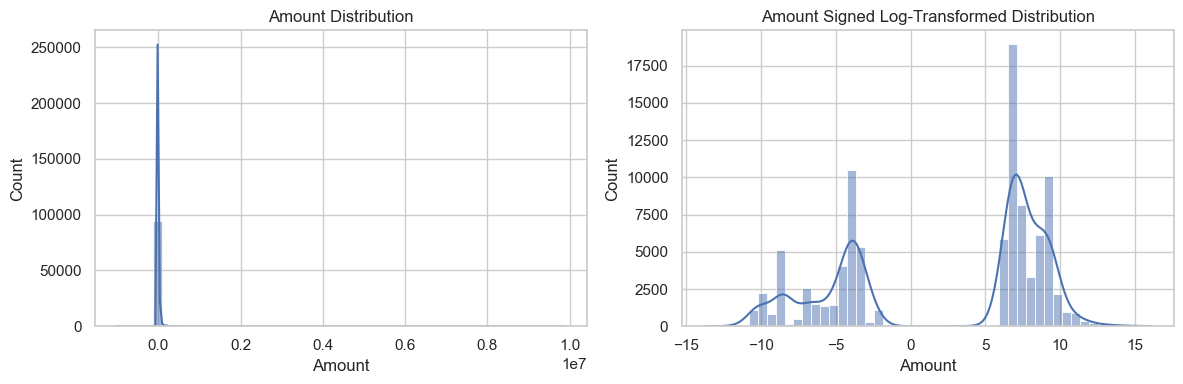

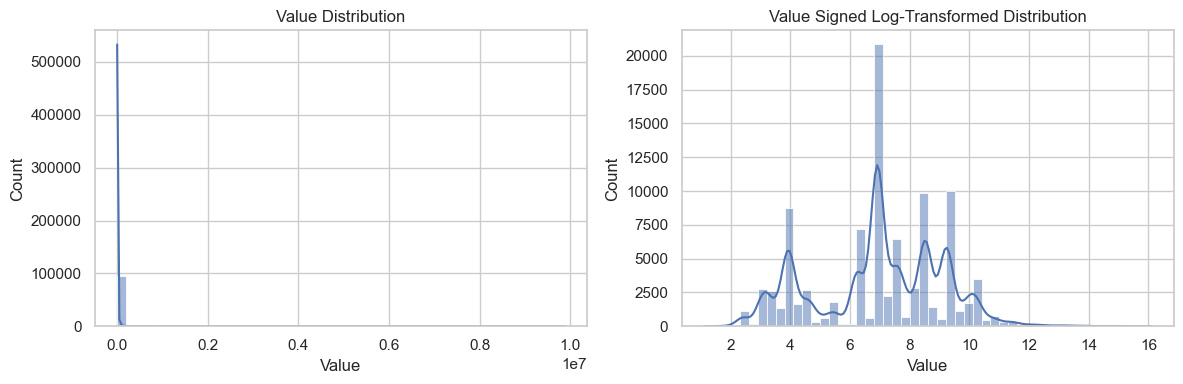

In [9]:
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original distribution
    sns.histplot(data[col], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"{col} Distribution")
    
    # Signed log transform
    transformed = np.sign(data[col]) * np.log1p(np.abs(data[col]))
    sns.histplot(transformed, bins=50, kde=True, ax=axes[1])
    axes[1].set_title(f"{col} Signed Log-Transformed Distribution")
    
    plt.tight_layout()
    plt.show()

The original distributions of Amount and Value are heavily right-skewed with extreme outliers. Applying a log transformation compresses the range, reduces skewness, and makes the distributions closer to normal, which can improve the stability and performance of downstream models.

### Outlier Detection

In [10]:
eda.outlier_metrics(numerical_cols)

,lower_bound,upper_bound,outlier_count,outlier_pct
Amount,-4325.0,7075.0,24441.0,0.255493
Value,-6812.5,12087.5,9021.0,0.094301


* For Amount, values outside the range  −4325 , 7075 are considered outliers. About 25.5% of transactions fall outside this range, indicating a significant presence of extreme values.
* For Value, outliers are outside  − 6812.5 , 12087.5, with roughly 9.4% of data points classified as outliers.

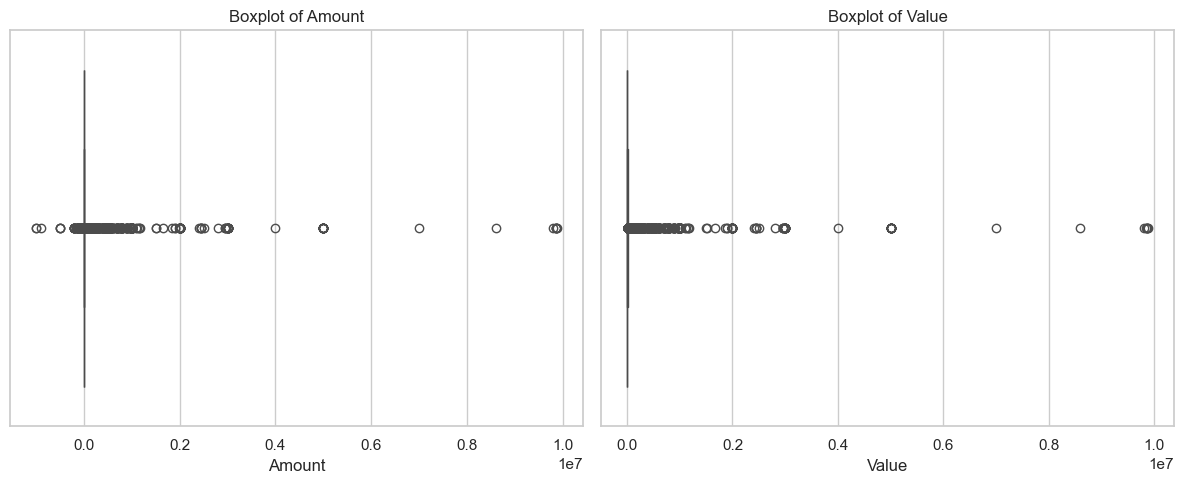

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=data[col], ax=axes[i], orient='h')
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


### Distribution of Categorical Features

In [12]:
categorical_cols = ["ChannelId", "ProductCategory", "ProviderId", "PricingStrategy"]

eda.categorical_metrics(categorical_cols)

,num_categories,top_category_pct,entropy
ChannelId,4.0,0.595168,0.754752
ProductCategory,9.0,0.474640,0.941039
ProviderId,6.0,0.399208,1.299974
PricingStrategy,4.0,0.834689,0.526804


Entropy measures category diversity: higher values → more uniform distribution; lower values → one category dominates.

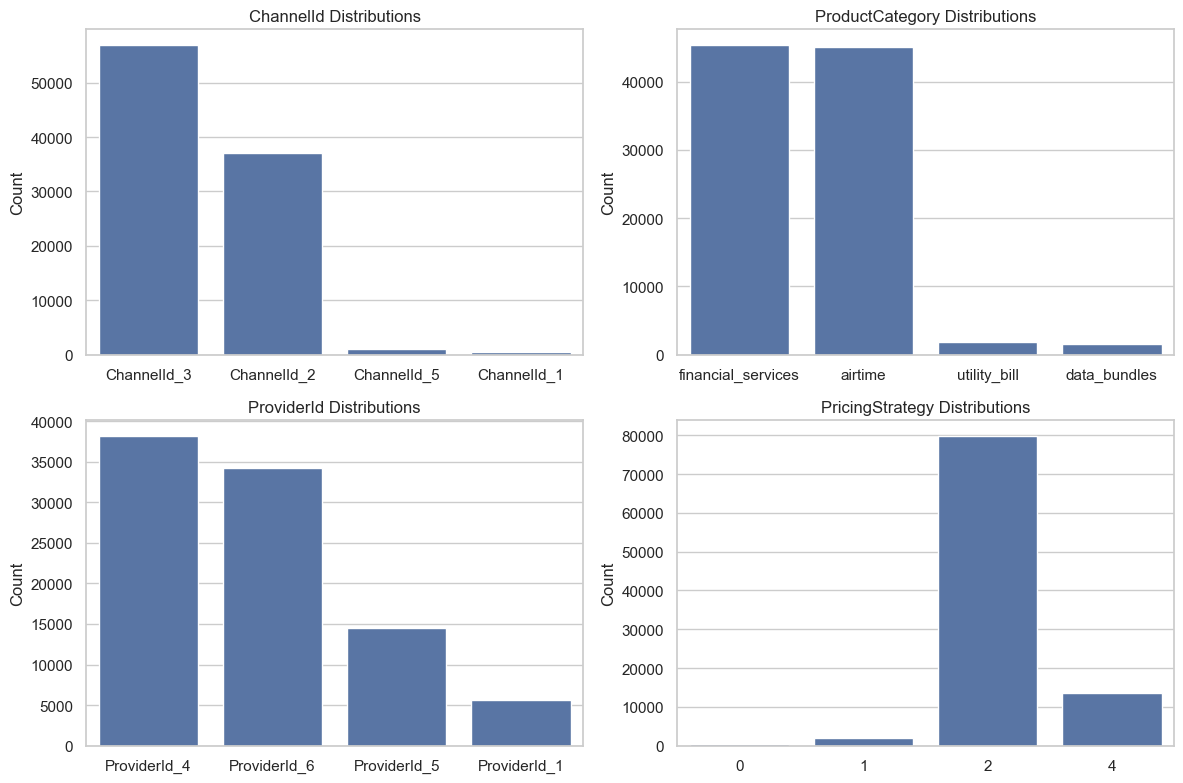

In [13]:
n_cols = 2  # number of columns of subplots
n_rows = (len(categorical_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    counts = data[col].value_counts().head(4)
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i])
    axes[i].set_title(f"{col} Distributions")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- ChannelId – Mostly concentrated in ChannelId_3 (~60%), it has a moderate diversity (entropy ≈ 0.75).
- ProductCategory – Somewhat balanced across categories (~47% finanical_services), it has a moderate diversity (entropy ≈ 0.94).
- ProviderId – Fairly evenly distributed across providers (~40% ProviderId_4), it has the highest diversity (entropy ≈ 1.30).
- PricingStrategy – Heavily dominated by one strategy (~83%), it has a low diversity (entropy ≈ 0.53).

### Correlation Analysis

In [14]:
corr = eda.correlation_matrix(numerical_cols)
print(corr)

          Amount     Value
Amount  1.000000  0.989692
Value   0.989692  1.000000


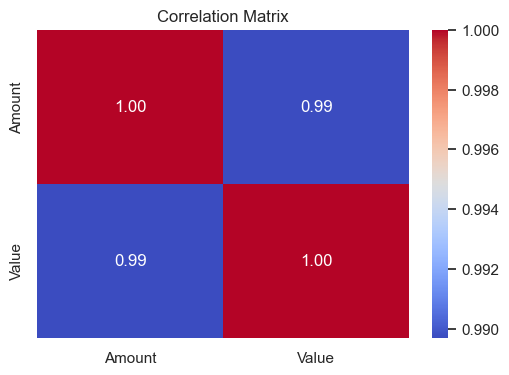

In [15]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Amount and Value columns are very strongly correlated (~0.99), which means they essentially move together.